# Programming Classifiers with Scikit Learn
#### By Jennifer Grannen and Osher Lerner

If you’ve been following the crash course, you’ve learned about modern machine learning tools from gradient descent to decision trees. In this post, we’re going to put pen to paper (or digits to keyboard) and take a crack at implementing them. Specifically, we’ll be programming SVM, logistic regression, and decision tree classification models to predict the presence of heart disease.


## Programming Setup

All of the code will be run using a jupyter notebook -- an interactive way to write, run, and visualize blocks of code. Jupyter notebooks are standard practice in the field because of how they naturally support the flow of machine learning experiments.

You can find this one, along with its utils and data at [https://github.com/mlberkeley/blog-resources/tree/master/ProgrammingClassifiers](https://github.com/mlberkeley/blog-resources/tree/master/ProgrammingClassifiers).

Let’s first import all the libraries we’ll be using.  


In [1]:
import sklearn
from sklearn import svm, tree, ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
np.random.seed(0)

Pandas and numpy will be helpful to store our data and perform operations on it. We will use matplotlib, a popular library for visualizing models and datasets. Last, we’ll import scikit-learn for some pre-implemented classifiers that we’ll use later.

Now let’s load our dataset. We’ll use Pandas to read in the csv file into a dataframe, to make it easy to work with later.

In [2]:
data = pd.read_csv("heart.csv")
feature_names = data.columns
discrete_features = ["sex", "cp", "fbs", "restecg", "exang", "ca", "thal"]
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


For each data point we have 14 features, one to predict (the presence of heart disease), and 13 others like sex, cholestrol level, chest pain, and electrocardiographic results. This data was collected in various hospitals in Europe, and for more information about it, visit https://www.kaggle.com/ronitf/heart-disease-uci#heart.csv. 

As we saw in [_Crash Course 3: The Bias-Variance Dilemma_](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-3-4a5bfd72294a), to experiment with machine learning models we first need to split our data into a training and test set so that we have independent data for evaluation and don’t cheat. Let’s randomly shuffle our data and set aside 10,000 examples for the test set. We usually split our data to be 80% train and 20% test.

In [3]:
def split_test_train(data, percent_test):
    test_size = int(percent_test*len(data))
    test_indices = np.random.choice(data.index, size=test_size, replace=False)
    train_indices = [i for i in data.index if i not in test_indices]
    train_df = data.iloc[train_indices]
    train_Y = train_df["target"]
    train_X = train_df.drop("target", axis=1)
    test_df = data.iloc[test_indices]
    test_Y = test_df["target"]
    test_X = test_df.drop("target", axis=1)
    return train_X, train_Y, test_X, test_Y

In [4]:
train_X, train_Y, test_X, test_Y = split_test_train(data, 0.2)

For visualizations, we will also use a randomly generated 2-dimensional dataset with only age and cholesterol features.

In [5]:
rand_data = utils.generate_random_data()
r_train_X, r_train_Y, r_test_X, r_test_Y = split_test_train(rand_data, 0.5)

## SVMs

The first algorithm we’ll use to classify this data is a support vector machine. As we covered in Part 2 of the crash course, SVMs are a very popular and versatile method for classification: they find a linear decision boundary which maximizes its distance from the data points closest to it (known as the **support vectors**). Calculating the “optimal” decision boundary (the one with the widest margin between the positive and negative predictions) is a tough (though interesting) problem. Fortunately, the mathematical details of this are implemented and packaged for us in ML libraries, such as scikit-learn for Python.

Let’s use sklearn to construct and train an SVM classifier.


In [6]:
clf = sklearn.svm.LinearSVC()
clf.fit(r_train_X, r_train_Y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Notice how short that was! Libraries like sklearn implement widely-used algorithms for us and make our lives easy by providing functions for us to classify our own data.

Let’s visualize what the model learned: we’ll plot the decision boundary that it learned, which tells us how it decided to split our training data into cases with and without heart disease.

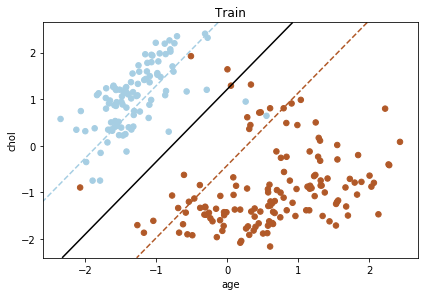

Train accuracy: 0.9789915966386554


In [7]:
utils.plot_SVM(clf, r_train_X, r_train_Y, title="Train")
print("Train accuracy:", clf.score(r_train_X, r_train_Y))

It’s spot on! Notice how the decision boundary lies as far as it can from each individual datapoint, maximizing the length of the support vectors, and how it sacrifices misclassifying a few points to better fit the rest. But the true test is how it performs on data it didn’t see during training. How accurate are its classifications on the test set?

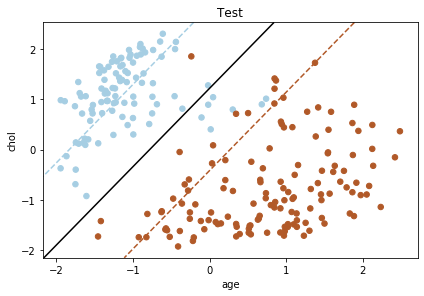

Test accuracy: 0.9662447257383966


In [8]:
utils.plot_SVM(clf, r_test_X, r_test_Y, title="Test")
print("Test accuracy:", clf.score(r_test_X, r_test_Y))

There’s a lot of misclassified points, i.e. points on the wrong side of the decision boundary. Perhaps we matched our training data too closely, instead of learning a general pattern. To stop a machine learning model from overfitting, we want to add regularization. [Recall](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-2-3046b4a7f943) that for SVMs, we use a **regularization parameter** “c” to control how much we penalize points violating the margin.

If we increase regularization (by decreasing C), our model will be less sensitive to points near the margin, even if it misclassifies them, so it can better fit the general trend. Let’s fit a classifier with higher regularization and see how it does:

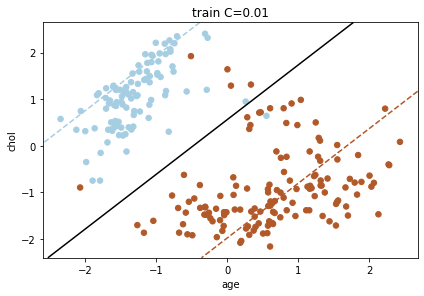

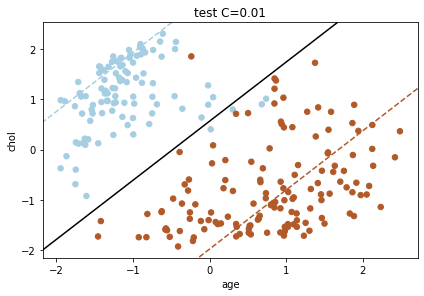

Train accuracy: 0.9747899159663865
Test accuracy: 0.9789029535864979


In [9]:
c = 0.01
clf = sklearn.svm.LinearSVC(C=c)
clf.fit(r_train_X, r_train_Y)

utils.plot_SVM(clf, r_train_X, r_train_Y, title="train C={}".format(c))
utils.plot_SVM(clf, r_test_X, r_test_Y, title="test C={}".format(c))
print("Train accuracy:", clf.score(r_train_X, r_train_Y))
print("Test accuracy:", clf.score(r_test_X, r_test_Y))

Despite the training accuracy going down a little, regularizing our model increased test accuracy! What if we made C even smaller, or a little bigger -- how would we know what the best regularization amount is? This is an example of a classic problem called “hyperparameter” tuning. Hyperparameters define the configuration of our model -- while “parameters” are automatically learned through optimization like gradient descent using the training data, we manually select the “hyperparameters” we think will make the best model. Yup, it’s that janky. Since we don’t fully understand which models or hyperparameters will work optimally for a given problem, it’s common practice to simply try a range of them and empirically see which performs the best!

However, if we tested a bunch of configurations and simply picked the one that performed best on our test data, we’d be in danger of overfitting our test data. Recall the original reason we set aside the test data was so that our model wouldn’t only learn the data it was given, but generalize. If we run many experiments with the same test data, even if each model can only see the training data, we would be artificially selecting for models which fit the specific test set we use! In order to compare our models but ensure we pick the most general one, rather than the one which best fits a specific test set, we use [cross-validation](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-4-the-bias-variance-dilemma-a94e60ec1d3): evaluation by splitting our training and test sets in many different ways and averaging how well the model generalized from each training set to its respective test set.

Let’s evaluate SVMs with regularization values of C from 10^-6 to 10^6 using cross-validation on the real – and much more complex – heart dataset. Note that using all 13 features, we will no longer be able to visualize the decision boundary on a 2D graph.

C = 0.1 achieved best val accuracy: 0.8311224489795919


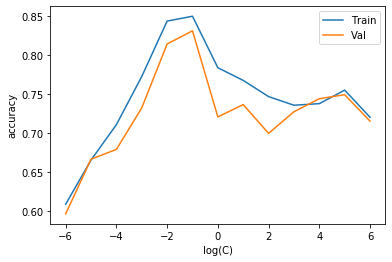

In [10]:
np.random.seed(0)
cs = [1000000, 100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
train_scores, val_scores = [], []
for c in cs:
    train_score, val_score = utils.cross_validate_SVM(c, train_X, train_Y)
    train_scores.append(train_score)
    val_scores.append(val_score)

plt.plot(np.log10(cs), train_scores, label="Train")
plt.plot(np.log10(cs), val_scores, label="Val")
plt.xlabel("log(C)")
plt.ylabel("accuracy")
plt.legend(loc="best")

best_i = np.argmax(val_scores)
best_c, best_score = cs[best_i], val_scores[best_i]
print("C =", best_c, "achieved best val accuracy:", best_score)

Our experiment found the best regularization parameter to be C=0.01, which got us an accuracy of 83.1%! That’s pretty good for such complex data, but can we do even better? One approach is to tune more hyperparameters of our SVM, such as choosing a [nonlinear kernel](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-2-3046b4a7f943) to make our data more linearly separable. In fact, there are many hyperparameters you can tweak; see [sklearn’s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for more details.

In general, SVM’s are computationally efficient, versatile models for classifying datasets with simple boundaries, but they can require some hyperparameter tuning to get in the sweet spot between over- and under-fitting. For the rest of this article, we’ll look at implementing entirely different approaches to the classification task and see how they compare.


## Logistic Regression

So we just used sklearn to train a Support Vector Machine, but now we’ll be implementing Logistic Regression in some more detail. Recall from [_Crash Course 2: SVMs, Perceptrons, and Logistic Regression_](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-2-3046b4a7f943) that logistic regression is a method of predicting probabilities for binary classification, rather than simply predicting true or false. We’ll be assigning a weight to each feature of our data, performing a weighted sum, then applying the logistic function to the output to get a probability between 0 and 1 of a certain datapoint having heart disease.

![](sigmoid_equation.png)
![](sigmoid_graph.png)

Let’s initialize a weight vector 𝜽 at random

In [11]:
np.random.seed(0)
num_features = r_train_X.shape[1]
r_theta = np.random.random(num_features)

Now, let’s define the logistic function, commonly known as a “sigmoid” curve. This curve is an example of a nonlinear activation, a key mechanism in learning complex patterns. 

In [12]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

Using 𝜽 and the sigmoid function, we can use our model to make predictions!

In [13]:
def predict(theta, X):
    linear_combination = X.dot(theta)
    return sigmoid(linear_combination)

Given an input vector of features, predict will weigh and sum each feature, then apply the sigmoid to return a probability between 0 and 1. Let’s plot our predictions!

In [14]:
def calc_accuracy(predictions, y):
    predictions, y = predictions.to_numpy(), y.to_numpy()
    correct = 0
    total = len(y)
    for i in range(total):
        if round(predictions[i]) == y[i]:
            correct += 1
    return correct/total

Initial train accuracy: 0.4117647058823529


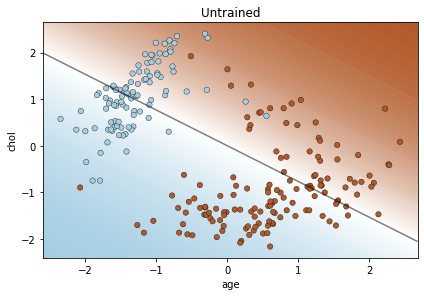

In [15]:
predictions = predict(r_theta, r_train_X)
print("Initial train accuracy:", calc_accuracy(predictions, r_train_Y))
utils.plot_logistic(predict, r_theta, r_train_X, r_train_Y, "Untrained")

Well, that went poorly, but that’s because we haven’t trained the classifier! Currently we’re using completely random weights, so our model isn’t even aware of our data. To find good weights, we first need a loss function to mathematically define how bad a given model is, then compute the weights that minimize this loss.

For tasks in which we predicted a value, like the price of a house, the loss we used was the mean squared error. However, now we’re predicting a probability of being in class 1, and we want to compare our predicted probability with the true probability of either 0% if the label is no heat disease or 100% if the label is positive for heart disease. To measure error we use a formalism of “distance” between probability distributions called cross entropy. The details are beyond the scope of this post, but by minimizing the cross entropy between our predicted probabilities and the true labels we will get the optimal logistic regression classifier. Let’s run gradient descent to traverse through different possible weights until we find the ones that minimize our loss.

In [16]:
def train(theta, X, Y, learning_rate=0.001, max_iter=10000):
    initial_predictions = predict(theta, X)
    initial_loss = utils.cross_entropy(initial_predictions, Y)
    losses = [initial_loss]

    for i in range(max_iter):
        gradient = utils.cross_entropy_gradient(theta, X, Y)
        theta = theta - learning_rate * gradient

        predictions = predict(theta, X)
        loss = utils.cross_entropy(predictions, Y)

        if abs(loss - losses[-1]) < 0.0001:
            losses.append(loss)
            break # Converged
        losses.append(loss)

    utils.plot_training(losses)
    return theta

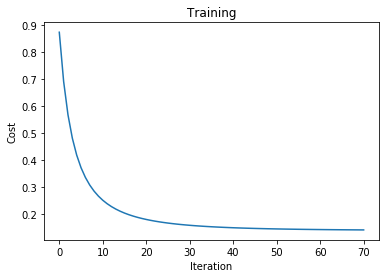

In [17]:
r_theta = train(r_theta, r_train_X, r_train_Y)

Let’s see how the new model performs!

Trained accuracy: 0.9453781512605042


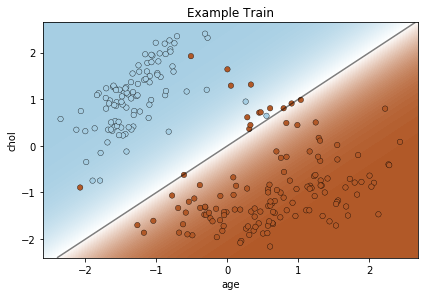

In [18]:
predictions = predict(r_theta, r_train_X)
print("Trained accuracy:", calc_accuracy(predictions, r_train_Y))
utils.plot_logistic(predict, r_theta, r_train_X, r_train_Y, "Example Train")

Look at that, we have a decision boundary similar to our SVM, but now we have precise probabilities for each of our predictions, with great accuracy too! These machine learning models aren’t just black boxes, they’re made of math we can understand and code. If you’re curious about the implementation of gradient descent optimization, feel free to check out the notebook for this post.

Finally, let's use logistic regression on the real 13-feature dataset. Again, although we can't visualize the decision boundary, we can measure the accuracy on this much more difficult prediction task. To help stabilize training, we'll also normalize our data such that each feature will be centered around 0 and have a standard deviation of 1. We'll cover normalization in depth on a future article.

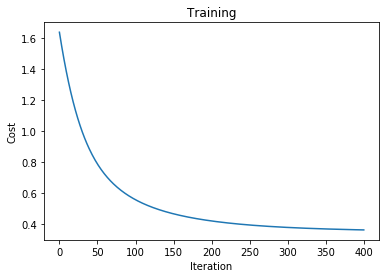

Train accuracy: 0.8518518518518519
Test accuracy: 0.8833333333333333


In [19]:
num_features = train_X.shape[1]
theta = np.random.random(num_features)

def normalize(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

theta = train(theta, normalize(train_X), train_Y, learning_rate=0.0001)

train_predictions = predict(theta, normalize(train_X))
test_predictions = predict(theta, normalize(test_X))
print("Train accuracy:", calc_accuracy(train_predictions, train_Y))
print("Test accuracy:", calc_accuracy(test_predictions, test_Y))

## Decision Trees

Recall from [_Crash Course 5: Decision Trees and Ensemble Models_](https://medium.com/@ml.at.berkeley/machine-learning-crash-course-part-5-decision-trees-and-ensemble-models-dcc5a36af8cd), a decision tree is another type of classification algorithm that splits on features to form a tree, and a specific combination of features is labelled. For our decision tree classifier, we need to select features on which to split our data. Each data point has 13 features. Splitting on all 13 of our features would be pretty costly - your tree would end up having 2^13 (or 8192) leaves! Let’s pick features that we think will be most helpful in capturing the variance of our data. Since our data is looking at whether a patient has heart disease, we’ll use the age, cholesterol level, and chest pain features. Below is some code implementing a simple decision tree classifier, try and understand how it works! 


In [20]:
def classify(x):
    if x["age"].values[0] > 55:
        if x["chol"].values[0] > 220:
            if x["cp"].values[0] != 0: return 1
            else: return 0
        else:
            if x["cp"].values[0] == 1: return 1
            else: return 0
    else:
        if x["chol"].values[0] > 240:
            if x["cp"].values[0] != 0: return 1
            else: return 0
        else:
            if x["cp"].values[0] == 1: return 1
            else: return 0

In [21]:
def score(test_X, test_Y):
    correct = 0
    total = 0
    for x in test_X.index:
        total += 1
        row = test_X[test_X.index == x]
        label = test_Y[test_Y.index == x].values[0]
        pred = classify(row)
        if pred == label:
            correct += 1
    return correct/total
        
score(test_X, test_Y)

0.65

We got 65% accuracy - not bad! It's better than random guessing, but we can definitely still do better, especially with all the features we have in this dataset. As we mentioned before, continuing to manually add features will get really tedious really fast, so we'll turn to sklearn for help. 

Now, we will move on to using pre-implemented decision tree classifiers, where training the model will preselect features for us. We’ll use the `sklearn` library’s implementation again, like we did for SVM’s. First, let’s initialize our classifier and fit it to our data:

In [22]:
clf = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf.fit(train_X, train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Next we’ll see how well our classifier does on test data. One way is to score the entire model on our test data. 

In [23]:
clf.score(test_X, test_Y)

0.7833333333333333

We got 78.3% accuracy - better than the decision tree we implemented arbitrarily above! 

You might also wonder how specific points are classified. For example, if I have a person with a specific combination of characteristics, does our model think that person has heart disease? 

We tried to predict if an average person that is 65 years old, female, and with typical angina chest pain had heart disease. 

In [24]:
test_point = np.mean(train_X)
for dis in discrete_features:
    test_point[dis] = np.around(test_point[dis])
test_point["age"] = 65
test_point["sex"] = 0
test_point["cp"] = 1
print(test_point)
test_point = np.array(test_point).reshape((1, -1))
print("PREDICTION:", clf.predict(test_point)[0])

age          65.000000
sex           0.000000
cp            1.000000
trestbps    131.674897
chol        246.765432
fbs           0.000000
restecg       1.000000
thalach     149.711934
exang         0.000000
oldpeak       1.062963
slope         1.407407
ca            1.000000
thal          2.000000
dtype: float64
PREDICTION: 1


It looks like our classifier predicted a probability of greater than 0.5, so we label this point to be of class 1, indicating the presence of heart disease.

## Random Forests

While decision trees applied out-of-the-box achieve great accuracies, they’re not without shortcomings. As we discussed in the Decision Tree and Random Forest blog post, single decision trees are not very robust, and tend to overfit when we’re not careful with our hyperparameters -- they have very high variance. Let’s take a closer look at two of the hyperparameters of our classifier and see what changing them does to our accuracy. There are many other hyperparameters we can investigate, but for the purposes of this example, we’ll be dealing with tree depth and number of leaves.

Let’s first see what our hyperparameter values were for the Decision Tree we trained above. We’ll visualize the trees afterwards and see what features were used.

_Note: The feature names in the visualizations are abbreviations in the dataset. For full feature names, see the dataset source:_ https://www.kaggle.com/ronitf/heart-disease-uci#heart.csv

In [25]:
print("DEPTH:", clf.get_depth())
print("# LEAVES:", clf.get_n_leaves())

DEPTH: 9
# LEAVES: 36


Now let’s try some other values for the depth and number of leaves.

Test acc of new classifier with max depth 4 and max 4 leaf nodes: 0.8333333333333334


[Text(223.20000000000002, 190.26, 'cp <= 0.5\ngini = 0.496\nsamples = 243\nvalue = [111, 132]'),
 Text(167.4, 135.9, 'ca <= 0.5\ngini = 0.41\nsamples = 118\nvalue = [84, 34]'),
 Text(111.60000000000001, 81.53999999999999, 'thal <= 2.5\ngini = 0.492\nsamples = 55\nvalue = [24, 31]'),
 Text(55.800000000000004, 27.180000000000007, 'gini = 0.36\nsamples = 34\nvalue = [8, 26]'),
 Text(167.4, 27.180000000000007, 'gini = 0.363\nsamples = 21\nvalue = [16, 5]'),
 Text(223.20000000000002, 81.53999999999999, 'gini = 0.091\nsamples = 63\nvalue = [60, 3]'),
 Text(279.0, 135.9, 'gini = 0.339\nsamples = 125\nvalue = [27, 98]')]

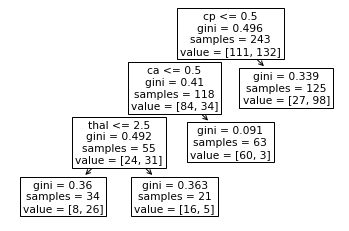

In [26]:
new_clf = sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=4, max_leaf_nodes=4)
new_clf.fit(train_X, train_Y)
new_score = new_clf.score(test_X, test_Y)
print("Test acc of new classifier with max depth 4 and max 4 leaf nodes:", new_score)

sklearn.tree.plot_tree(new_clf, feature_names=feature_names)

Test acc of new classifier with max depth 2 and max 3 leaf nodes: 0.7333333333333333


[Text(200.88000000000002, 181.2, 'cp <= 0.5\ngini = 0.496\nsamples = 243\nvalue = [111, 132]'),
 Text(133.92000000000002, 108.72, 'ca <= 0.5\ngini = 0.41\nsamples = 118\nvalue = [84, 34]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.492\nsamples = 55\nvalue = [24, 31]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.091\nsamples = 63\nvalue = [60, 3]'),
 Text(267.84000000000003, 108.72, 'gini = 0.339\nsamples = 125\nvalue = [27, 98]')]

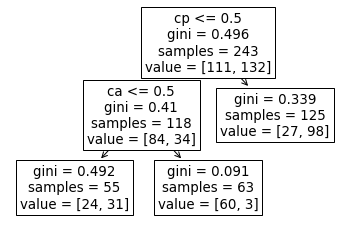

In [27]:
new_clf = sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=2, max_leaf_nodes=3)
new_clf.fit(train_X, train_Y)
new_score = new_clf.score(test_X, test_Y)
print("Test acc of new classifier with max depth 2 and max 3 leaf nodes:", new_score)

sklearn.tree.plot_tree(new_clf, feature_names=feature_names)

Another way to prevent overfitting is to use random forests, which take the average of the results of many, many randomly initialized decision trees. Luckily, we won’t implement this on our own (that might take a while!). Again, we’ll use sklearn’s implementation and see how it does:

In [28]:
clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
clf.fit(train_X, train_Y)
print("Test acc:", clf.score(test_X, test_Y))

Test acc: 0.8333333333333334


/Users/osherlerner/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


It looks like our Random Forest classifier did a lot better, with 83.3% accuracy this time! It combines information from a lot of different, individual Decision Tree models, making it an ensemble method. Ensemble methods offer a lot of advantages, like lower variance, but require a lot more compute to make many copies of the individual models. Decision Trees are relatively inexpensive to use, which make Random Forests a good choice for an ensembling method.

## Conclusion

Now that you’ve learned how to program SVMs, Logistic Regression, and Random Forests, try it for yourself! Pick an interesting problem where you think you could use an ML classifier, find a dataset for it, and use the tools you’ve learned to experiment with different models! The generality of the algorithms we use will mean that most of the code can be reused for many different tasks, and if you get stuck you can refer to online documentation. Make sure to show us what you come up with!